## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


sc21ls

Your full name:

Lohavani Sevverl

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [3]:
import cv2
import math
import csv
import numpy as np
import os
import torch
import torchvision
import torch.nn as nnet
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms
from torch import optim

from PIL import Image
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder

# replace with your own root directory
ROOT="C:\\Users\\HP\\Downloads\\AI Coursework\\Dataset"

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [4]:
# GPU support
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')

print(device)

cuda


In [6]:
class DataLoader(Dataset):
    def __init__(self, main_dir, transform):

        self.main_dir =main_dir
        self.transform = transform

        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return self.total_imgs[idx] ,torch.unsqueeze(tensor_image, 0)

In [7]:
transform1 = transforms.Compose([
    transforms.ToTensor()
])

dataset1 = ImageFolder(root="C:\\Users\\HP\\Downloads\\AI Coursework\\Dataset\\train_set",transform=transform1)
#print(len(dataset1.classes))
training_size = int(0.8 * len(dataset1))
validation_size = len(dataset1) - training_size
#print(validation_size)
training_dataset, validation_dataset = torch.utils.data.random_split(dataset1, [training_size, validation_size])
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=15, shuffle=True)

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [8]:
network = nnet.Sequential(
    nnet.Conv2d(in_channels=3,out_channels=8, kernel_size=3,padding=1),    # no padding, stride=1, dilation=1 by default
    nnet.ReLU(),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Conv2d(in_channels=8,out_channels=16, kernel_size=3,padding=1),
    nnet.ReLU(),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Conv2d(in_channels=16,out_channels=32, kernel_size=3,padding=1),
    nnet.ReLU(),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Flatten(),
    nnet.Linear(32*8*8,128),     # with 32x32 input, the feature map size reduces to 8x8 with 16 channels.
    nnet.ReLU(),
    nnet.Linear(128,30)
)

for para in network.parameters():
    print(para.shape)

torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([128, 2048])
torch.Size([128])
torch.Size([30, 128])
torch.Size([30])


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [9]:
def statistics(load, net):
    corr = 0
    sum1 = 0
    r_loss = 0
    num = 0
    with torch.no_grad():
        for data in load:
            imgs, labels = data
            output = net(imgs)      
            
            r_loss += loss_fn(output, labels)
            num += 1
            
            _, predicted = torch.max(output.data, 1)
            sum1 += labels.size(0)    # add in the number of labels in this minibatch
            corr += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return r_loss/num, corr/sum1

In [10]:
epochs = 250
result = "batch1.pt"
stat = np.zeros((4,epochs))
loss_fn = nnet.CrossEntropyLoss()
optimize = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
input1, label = next(iter(training_loader))
for epoch in range(epochs):  
    correct_ans = 0        
    sum1 = 0          
    r_loss = 0.0 
    optimize.zero_grad()

    output = network(input1)
    loss = loss_fn(output, label)
    loss.backward()
    optimize.step()

    r_loss = loss.item()
    
    _, predicted = torch.max(output.data, 1)
    sum1 += label.size(0)    
    correct_ans += (predicted == label).sum().item() 
    
    ltrn = r_loss
    atrn = correct_ans/sum1 
    ltst, atst = statistics(validation_loader, network)
    stat[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
    if(r_loss<=0.0):
        break

torch.save({"state_dict": network.state_dict(), "stats": stat}, result)

epoch: 0 training loss:  3.402 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 1 training loss:  3.402 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 2 training loss:  3.402 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 3 training loss:  3.402 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 4 training loss:  3.401 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 5 training loss:  3.401 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.0%
epoch: 6 training loss:  3.401 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%
epoch: 7 training loss:  3.401 training accuracy:  1.6%  test loss:  3.403 test accuracy:  2.9%
epoch: 8 training loss:  3.400 training accuracy:  4.7%  test loss:  3.403 test accuracy:  2.7%
epoch: 9 training loss:  3.400 training accuracy:  6.2%  test loss:  3.403 test accuracy:  2.7%
epoch: 10 training loss:  3.399 training

epoch: 85 training loss:  3.348 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 86 training loss:  3.347 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 87 training loss:  3.346 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 88 training loss:  3.345 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 89 training loss:  3.344 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 90 training loss:  3.343 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 91 training loss:  3.342 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 92 training loss:  3.341 training accuracy:  9.4%  test loss:  3.406 test accuracy:  3.1%
epoch: 93 training loss:  3.340 training accuracy:  9.4%  test loss:  3.407 test accuracy:  3.1%
epoch: 94 training loss:  3.338 training accuracy:  9.4%  test loss:  3.407 test accuracy:  3.1%
epoch: 95 training loss:  3.33

epoch: 169 training loss:  3.128 training accuracy:  6.2%  test loss:  3.577 test accuracy:  3.6%
epoch: 170 training loss:  3.125 training accuracy:  7.8%  test loss:  3.587 test accuracy:  3.4%
epoch: 171 training loss:  3.122 training accuracy:  9.4%  test loss:  3.596 test accuracy:  3.3%
epoch: 172 training loss:  3.119 training accuracy:  7.8%  test loss:  3.606 test accuracy:  3.5%
epoch: 173 training loss:  3.116 training accuracy:  7.8%  test loss:  3.615 test accuracy:  3.4%
epoch: 174 training loss:  3.113 training accuracy:  7.8%  test loss:  3.625 test accuracy:  3.4%
epoch: 175 training loss:  3.111 training accuracy:  9.4%  test loss:  3.635 test accuracy:  3.4%
epoch: 176 training loss:  3.109 training accuracy:  9.4%  test loss:  3.645 test accuracy:  3.4%
epoch: 177 training loss:  3.106 training accuracy:  9.4%  test loss:  3.655 test accuracy:  3.5%
epoch: 178 training loss:  3.104 training accuracy:  9.4%  test loss:  3.664 test accuracy:  3.5%
epoch: 179 training 

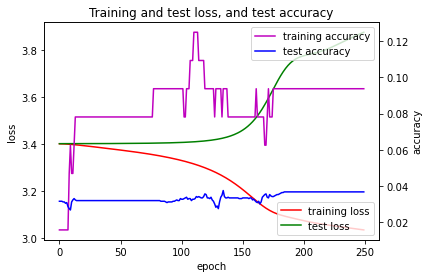

In [11]:
result = "batch1.pt"
data1 = torch.load(result)
stat = data1["stats"]

figure, axis = plt.subplots()
plt.plot(stat[0], 'r', label = 'training loss', )
plt.plot(stat[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
axis2=axis.twinx()
axis2.plot(stat[1], 'm', label = 'training accuracy')
axis2.plot(stat[3], 'b', label = 'test accuracy')
axis2.set_ylabel('accuracy')
plt.legend(loc='upper right')
figure.savefig("sample.svg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [12]:
epochs = 200
epochs_stp = 10
epochs_unimprove = 0
stop_soon = False
result = "200epochs.pt"
stat = np.zeros((4,epochs))
loss_fn = nnet.CrossEntropyLoss()
optimize = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
min_loss=np.Inf
for epoch in range(epochs):  
    corr = 0          
    sum1 = 0            
    r_loss = 0.0   
    num = 0                
    for data in training_loader:
        input, label = data
        optimize.zero_grad()
        output = network(input)
        loss = loss_fn(output, label)
        loss.backward()
        optimize.step()
        r_loss += loss.item()
        num += 1
        _, predicted = torch.max(output.data, 1)
        sum1 += label.size(0)    
        corr += (predicted == label).sum().item()  
    
    ltrn = r_loss/num
    atrn = corr/sum1 
    ltst, atst = statistics(validation_loader, network)
    
    if ltst<min_loss:
        epochs_unimprove = 0
        min_loss = ltst
    else:
        epochs_unimprove+=1
    if epoch > 5 and epochs_unimprove == epochs_stp:
        print('Early stopping!' )
        stop_soon = True
        break
    stat[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

torch.save({"state_dict": network.state_dict(), "stats": stat}, result)

epoch: 0 training loss:  3.437 training accuracy:  3.7%  test loss:  3.408 test accuracy:  3.1%
epoch: 1 training loss:  3.404 training accuracy:  3.4%  test loss:  3.404 test accuracy:  3.1%
epoch: 2 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.1%
epoch: 3 training loss:  3.400 training accuracy:  3.7%  test loss:  3.401 test accuracy:  3.2%
epoch: 4 training loss:  3.399 training accuracy:  3.7%  test loss:  3.400 test accuracy:  3.3%
epoch: 5 training loss:  3.398 training accuracy:  4.4%  test loss:  3.399 test accuracy:  5.0%
epoch: 6 training loss:  3.396 training accuracy:  5.8%  test loss:  3.397 test accuracy:  5.6%
epoch: 7 training loss:  3.395 training accuracy:  6.1%  test loss:  3.395 test accuracy:  5.7%
epoch: 8 training loss:  3.391 training accuracy:  6.3%  test loss:  3.391 test accuracy:  4.4%
epoch: 9 training loss:  3.386 training accuracy:  5.3%  test loss:  3.384 test accuracy:  5.9%
epoch: 10 training loss:  3.374 training

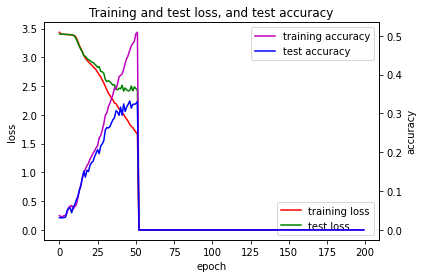

In [13]:
result = "200epochs.pt"
data = torch.load(result)
stat = data["stats"]

figure, axis = plt.subplots()
plt.plot(stat[0], 'r', label = 'training loss', )
plt.plot(stat[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
axis1=axis.twinx()
axis1.plot(stat[1], 'm', label = 'training accuracy')
axis1.plot(stat[3], 'b', label = 'test accuracy')
axis1.set_ylabel('accuracy')
plt.legend(loc='upper right')
figure.savefig("sample1.svg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [14]:
from torchvision.datasets import ImageFolder
transform1 = transforms.Compose([                        
   transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
  
])

dataset1 = ImageFolder(root="C:\\Users\\HP\\Downloads\\AI Coursework\\Dataset\\train_set",transform=transform1)
#print(dataset1)
#print(len(dataset1.classes))
training_size = int(0.90 * len(dataset1))
validation_size = len(dataset1) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset1, [training_size, validation_size])## spliting train_set for both train_dataset and validation_set.
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True,num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=64, shuffle=True,num_workers=2)

In [15]:
for data1 in training_loader:
      input1, label = data1
      print(input1[0].shape)
      break

torch.Size([3, 64, 64])


In [16]:
model_122c = nnet.Sequential(
    nnet.Conv2d(in_channels=3,out_channels=50, kernel_size=3,padding=1),  
    nnet.ReLU(inplace=True), 
    nnet.Conv2d(in_channels=50,out_channels=75,  kernel_size=3,padding=1),
    nnet.ReLU(inplace=True),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Dropout(p=0.5),
    nnet.Conv2d(in_channels=75,out_channels=125,  kernel_size=3,padding=1),
    nnet.ReLU(inplace=True),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Conv2d(in_channels=125,out_channels=256,  kernel_size=3,padding=1),
    nnet.ReLU(inplace=True),
    nnet.MaxPool2d(kernel_size=2, stride=2),
    nnet.Dropout(p=0.25),
    nnet.Flatten(),
    nnet.Linear(256*8*8,1000), 
    nnet.Dropout(p=0.25),  
    nnet.Linear(1000,500),
    nnet.Dropout(p=0.25),  
    nnet.Linear(500,200),
    nnet.Dropout(p=0.5),
    nnet.Linear(200,30)
)

for param in model_122c.parameters():
    print(param.shape)

torch.Size([50, 3, 3, 3])
torch.Size([50])
torch.Size([75, 50, 3, 3])
torch.Size([75])
torch.Size([125, 75, 3, 3])
torch.Size([125])
torch.Size([256, 125, 3, 3])
torch.Size([256])
torch.Size([1000, 16384])
torch.Size([1000])
torch.Size([500, 1000])
torch.Size([500])
torch.Size([200, 500])
torch.Size([200])
torch.Size([30, 200])
torch.Size([30])


In [17]:
def statistics1(loader, model_122c):
    corr = 0
    sum1 = 0
    r_loss = 0
    num = 0    
    with torch.no_grad():
        for data1 in loader:
            imgs, label = data1
            output = model_122c(imgs)      

            r_loss += loss_fn(output, label)
            num += 1
 
            _, predicted = torch.max(output.data, 1)
            sum1 += label.size(0)    
            corr += (predicted == label).sum().item()  
            
    return r_loss/num, corr/sum1 

In [18]:
from torch.optim import lr_scheduler
epochs = 10
result = "finetune.pt"
stat = np.zeros((4,epochs))
loss_fn = nnet.CrossEntropyLoss()
optimize = optim.Adam(model_122c.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimize, 'min', patience = 5)## lr will change with patience 5
min_loss = np.Inf
for epoch in range(epochs):  
    corr = 0          
    sum1 = 0            
    r_loss = 0.0
    num = 0
    for data1 in training_loader:
        input1, label = data1
        optimize.zero_grad()

        output = model_122c(input1)
        loss = loss_fn(output, label)
        loss.backward()
        optimize.step()
    
        r_loss += loss.item()
        num += 1

        _, predicted = torch.max(output.data, 1)
        sum1 += label.size(0)    
        corr += (predicted == label).sum().item()  
    
    ltrn = r_loss/num
    atrn = corr/sum1
    ltst, atst = statistics1(validation_loader, model_122c)
    scheduler.step(ltst/len(validation_loader))
    stat[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
torch.save({"state_dict": model_122c.state_dict(), "stats": stat}, result)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 19660800 bytes.

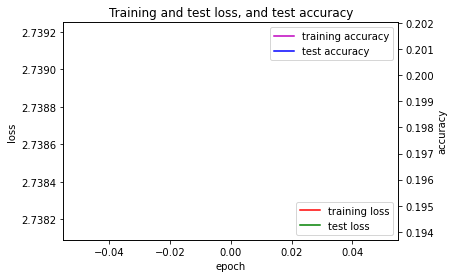

In [19]:
result = "finetune.pt"
data1 = torch.load(result)
stat = data1["stats"]

figure, axis = plt.subplots()
plt.plot(stat[0], 'r', label = 'training loss', )
plt.plot(stat[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
axis1=axis.twinx()
axis1.plot(stat[1], 'm', label = 'training accuracy')
axis1.plot(stat[3], 'b', label = 'test accuracy')
axis1.set_ylabel('accuracy')
plt.legend(loc='upper right')
figure.savefig("sample1.svg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

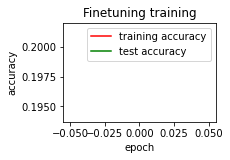

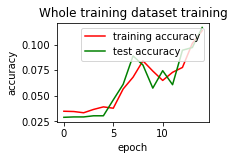

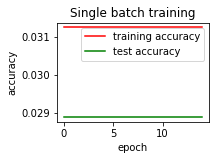

In [21]:
axis = plt.subplot(2,2,1)
result = "finetune.pt"
data1 = torch.load(result)
stat = data1["stats"]
plt.plot(stat[1], 'r', label =  'training accuracy', )
plt.plot(stat[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Finetuning training')
plt.legend(loc='upper right')
plt.show()

axis = plt.subplot(2,2,1)
result = "200epochs.pt"
data1 = torch.load(result)
stat = data1["stats"]
plt.plot(stat[1], 'r', label =  'training accuracy', )
plt.plot(stat[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Whole training dataset training')
plt.legend(loc='upper right')
plt.show()

axis = plt.subplot(2,2,1)
result = "batch1.pt"
data1 = torch.load(result)
stat = data1["stats"]
plt.plot(stat[1], 'r', label =  'training accuracy', )
plt.plot(stat[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Single batch training')
plt.legend(loc='upper right')
plt.show()

From single batch training we can observe that we cant acheive minimum acccuraacy for the validation data in through the epochs while training accuracy is increasing.

When trining on whole data set we can see that, by the end of the 50 epochs we got the validation accuracy of 35 percent and after that there we not observing any improvemnt in the validation loss .


After applying certain  data agumentation techniques mod,ifying the model layers (add dropout and linear layers)aand adding lr scheduler we can observer slight increase the the accuracy of the validation to 45 percent.

--> Double click here to respond


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



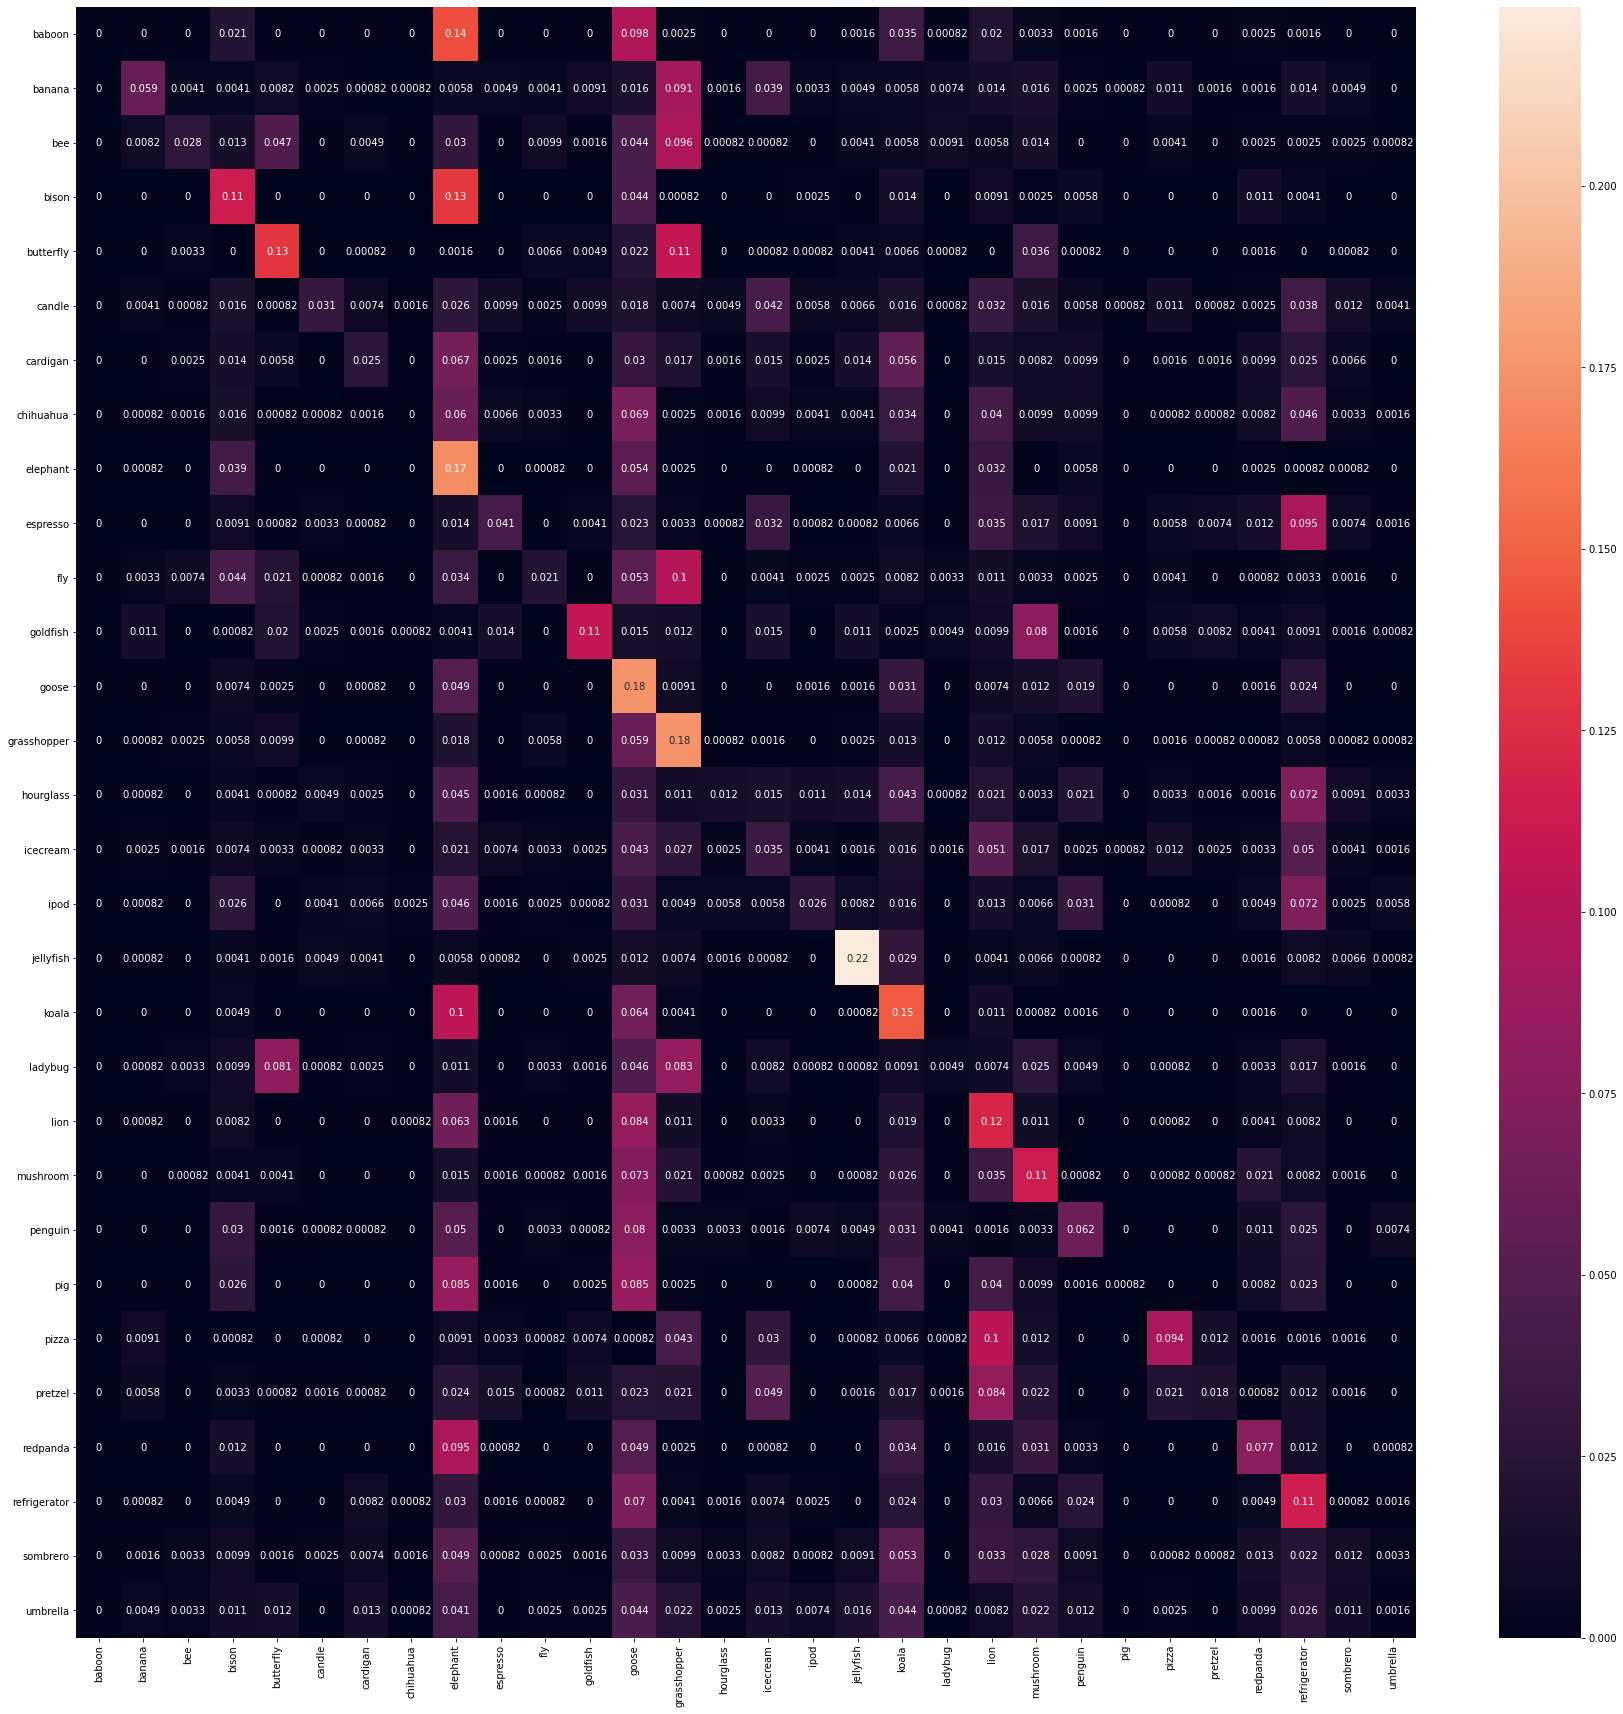

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

result = "finetune.pt"
data1 = torch.load(result)
model_122c.load_state_dict(data1["state_dict"])
model_122c.eval()
y_pred = []
y_true = []
list1=[]
for key in dataset1.class_to_idx.keys():
    list1.append(key)

for input1, label in training_loader:
    output = model_122c(input1) 
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) 
    label = label.data.cpu().numpy()
    y_true.extend(label) 

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in list1],
                     columns = [i for i in list1])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

What conclusions can be drawn from the confusion matrices?

We got certain class with more tha 20 percent correct predictions such as lion, jelly fish,bison, cardigan and pizza. However, we got false negatives for certain classes like pig, red panda classes where it is classfied wrongly as bison(animal). And other minor false negatives are bee, ice cream, pretezel, pizza which are classified as lion.



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [25]:
result = "finetune.pt"
data1 = torch.load(result)
model_122c.load_state_dict(data1["state_dict"])
model_122c.eval()
dataset1 = DataLoader(main_dir="C:\\Users\\HP\\Downloads\\AI Coursework\\Dataset\\test_set",transform=transform1 )

In [26]:
from torch.utils.data import DataLoader
prediction = []
for i in range(len(dataset1)):
    img_name, img = dataset1.__getitem__(i)
    output = model_122c(img)
    _, predicted1 = torch.max(output.data, 1)
    data1 = [img_name,predicted1.numpy()[0] ]  
    prediction.append(data1) 


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [21]:
from csv import writer
 
with open("sc21ls.csv", 'a', newline='') as f_object:  
    w_obj = writer(f_object)
    for data1 in prediction:
        w_obj.writerow(data1)
    f_object.close()



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [27]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in C:\Users\HP/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [29]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [30]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [31]:
def fetch_filters(layer_idx, model):
    filters = model.features[layer_idx].weight.data.clone()
    return filters

In [33]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10] 

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [34]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [35]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



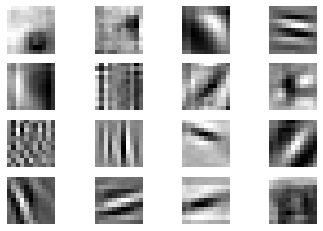

In [36]:
to_show = 16

plt_dim = int(math.sqrt(to_show))

for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [38]:
from PIL import Image
im = Image.open("man_bike.JPEG").convert("RGB")
print(im)

<PIL.Image.Image image mode=RGB size=500x375 at 0x228AAA4E490>


Run the code cell below to apply the image transformation expected by the model.

In [39]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [40]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
     
    model_wght = []
    conv_layers = []
    layers = []
    count = 0 
    max_pool = []
    model_children = list(model.children())

    for i in range(len(model_children[0])):
        child = model_children[0][i]
        layers.append(child)
        if type(child) == nnet.MaxPool2d:
            count += 1
 
    print(count)
    result = [layers[0](image)]
  
    for i in range(1, len(layers)):
        x = layers[i](result[-1])
        result.append(x)
        if len(result[i][0][0]) == len(result[i-1][0][0])// 2:
            max_pool.append(x)
       
    max_pool=[torch.tensor(a,requires_grad=False) for a in max_pool ]
    
    return max_pool

In [41]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

3


<ipython-input-40-6491f124238f>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_pool=[torch.tensor(a,requires_grad=False) for a in max_pool ]


For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [42]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

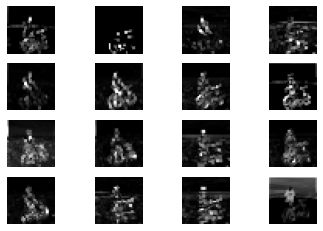

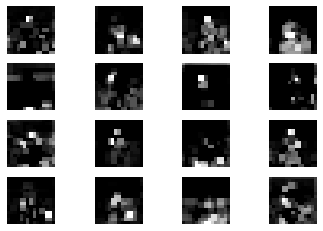

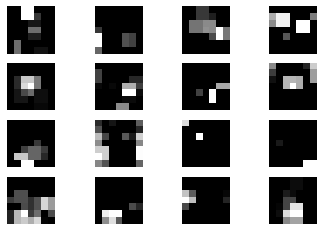

In [43]:
num = 16
plot_dimension = int(math.sqrt(num))

for j in range(3):
    for i, filter1 in enumerate(feature_maps[j][0].numpy()[:num]):
        plt.subplot(plot_dimension, plot_dimension, i+1)
        plt.imshow(filter1, cmap="gray")
        plt.axis('off')
    plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Double click here to respond.

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

--> Double click here to respond

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

--> Double click here to respond


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [44]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nnet.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nnet.Sequential(
            nnet.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nnet.ReLU(inplace=True),
            nnet.MaxPool2d(kernel_size=3, stride=2),
            nnet.Conv2d(64, 192, kernel_size=5, padding=2),
            nnet.ReLU(inplace=True),
            nnet.MaxPool2d(kernel_size=3, stride=2),
            nnet.Conv2d(192, 384, kernel_size=3, padding=1),
            nnet.ReLU(inplace=True),
            nnet.Conv2d(384, 256, kernel_size=3, padding=1),
            nnet.ReLU(inplace=True),
            nnet.Conv2d(256, 256, kernel_size=3, padding=1),
            nnet.ReLU(inplace=True),
            nnet.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nnet.AdaptiveAvgPool2d((6, 6))
        self.classifier = nnet.Sequential(
            nnet.Dropout(),
            nnet.Linear(256 * 6 * 6, 4096),
            nnet.ReLU(inplace=True),
            nnet.Dropout(),
            nnet.Linear(4096, 4096),
            nnet.ReLU(inplace=True),
            nnet.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [45]:
model = alexnet(pretrained=True)

In [46]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [47]:
print(output.shape)
print(pred_cls)

torch.Size([1, 1000])
tensor([[671]])


### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [48]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    output[:,-1].backward()
    
    # 2. get the gradients from the model placeholder variable
    grads = model.gradients
    assert list(grads.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    assert list(pooled_grads.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    for i in range(256):
        activations[:, i, :, :] *= pooled_grads[i]
    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.

    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap

In [49]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

torch.Size([7, 7])

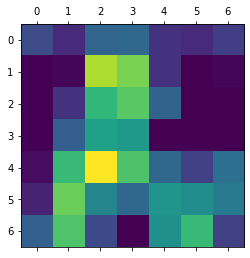

In [50]:
heatmap.shape #yes
# TO COMPLETE
plt.matshow(heatmap.squeeze())
heatmap.shape

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

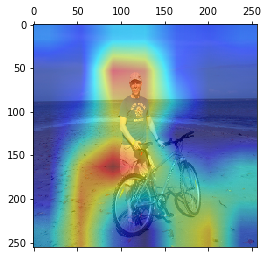

In [51]:
def display_heatmap(heatmap,image):

    (w, h) = (image.shape[0], image.shape[1])
    heatmap = cv2.resize(heatmap.numpy(), (w, h))

    numerator = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min()) + 1e-8
    heatmap_norm = numerator / denominator
    heatmap_norm = (heatmap_norm * 255).astype("uint8")
    heatmap_norm = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
    heatmap_norm = heatmap_norm * 0.4

    weighted_img = cv2.addWeighted(heatmap_norm, 0.7, image, 0.3, 0)
    numerator = weighted_img - np.min(weighted_img)
    denominator = (weighted_img.max() - weighted_img.min()) + 1e-8
    final_img = numerator / denominator
    final_img = (final_img * 255).astype("uint8")

    return final_img
  
img = cv2.imread('man_bike.JPEG')
img = cv2.resize(img,(256,256))
img = np.asarray(img, np.float64)

display = display_heatmap(heatmap,img)
plt.matshow(display[:, :, ::-1])

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

tensor([[1]])


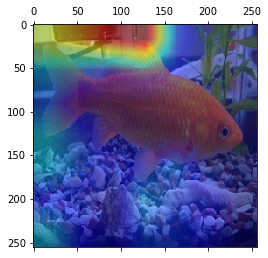

In [52]:
swimming = Image.open('goldfish.jpg')

# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

swimming = data_transform(swimming)
mod = alexnet(pretrained=True)

# pass our test image through our new model with the hook
output = mod(swimming.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)
print(pred_cls) # tensor([[291]])
percentage = nnet.functional.softmax(output, dim=1)[0] * 100  
 
# ggenerate heatmap
heatmap = generate_heatmap(output, pred_cls, mod, swimming.unsqueeze(0))
swimming = cv2.imread('goldfish.jpg')
# im2.shape (375, 500, 3) transforms.Resize(256) -> (3, 256, 256)
swimming = cv2.resize(swimming,(256,256))
swimming = np.asarray(swimming, np.float64)
show_result = display_heatmap(heatmap, swimming)
plt.matshow(show_result[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

We have tken grass image to classify in alex net.
Prediction we got is 'croquet ball'(522).

For the heat map we can say that it could not found any major features from the image, we got only one brigthly focused area which does not provide any major information to classify the image . 

As we use croquet ball in grass fileds we could have got the above result. 


--> Double click to respond here

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
